### Import the library :

In [1]:

import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import joblib

### Load all data files and check the type of data : 

In [2]:
df1 = pd.read_csv("data/combined_data_1.txt", header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df2 = pd.read_csv('data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)


In [3]:
# Concatenate the four DataFrames into one (work in Vscode)
df = pd.concat([df1, df2, df3, df4])

In [4]:
df.index = np.arange(0,len(df)) # sets the index of the DataFrame df
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


In [5]:
# # Concatenate the four DataFrames into one (work in google collab)

# df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

In [6]:
df.shape

(100498277, 2)

In [7]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


### Data viewing : 

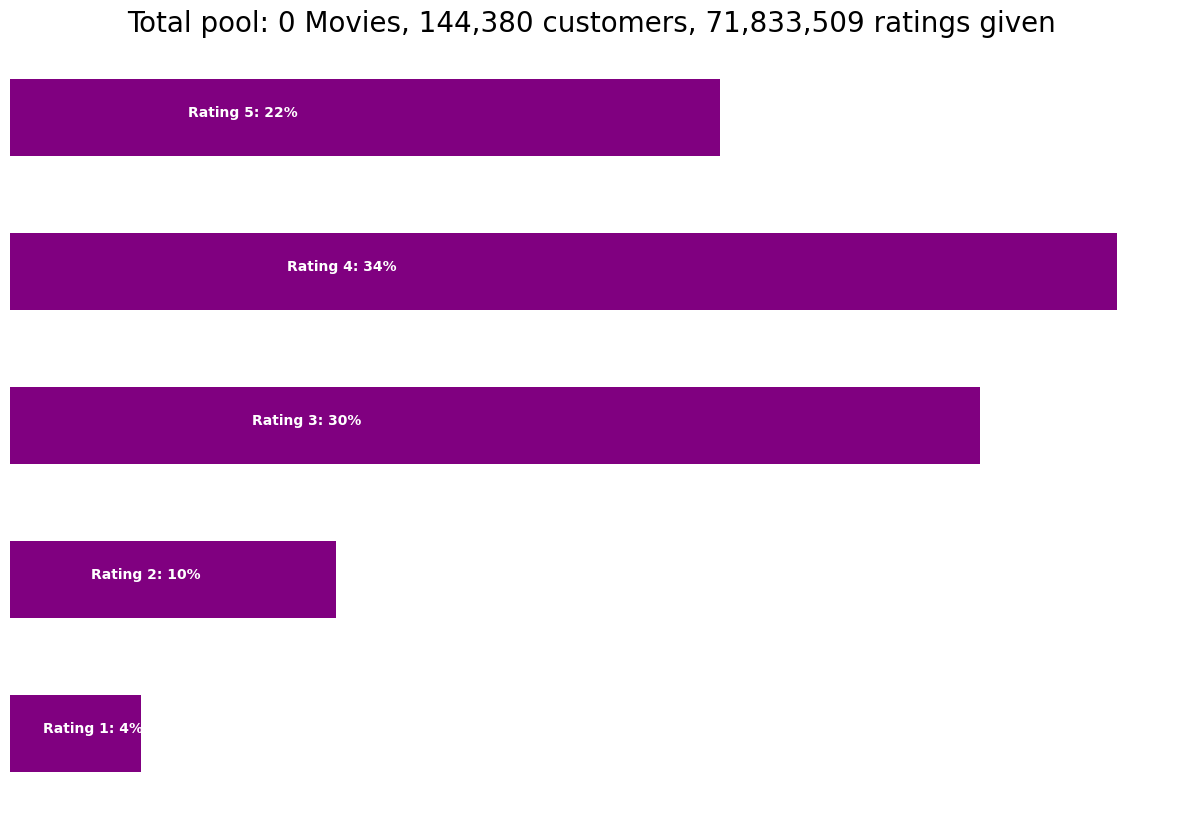

In [15]:
# Group the data in the DataFrame df by the 'Rating' column and count the number of occurrences of each unique value in that column
p = df.groupby('Rating')['Rating'].agg(['count'])

# Get the number of movies by counting the number of null values in the second column of the DataFrame df
movie_count = df.isnull().sum()[1]

# Get the number of customers by counting the number of unique values in the 'Cust_Id' column of the DataFrame df and subtracting the number of movies
cust_count = df['Cust_Id'].nunique() - movie_count

# Get the number of ratings by counting the number of non-null values in the 'Cust_Id' column of the DataFrame df and subtracting the number of movies
rating_count = df['Cust_Id'].count() - movie_count

# Create a horizontal bar chart from the DataFrame p, without a legend, with a figure size of (15,10) and a purple color
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10), color = 'purple')

# Add a title to the chart with the total number of movies, customers, and ratings
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)

# Hide the axes of the chart
plt.axis('off')

# For each possible rating value (from 1 to 5)
for i in range(1,6):
    # Add text to the chart indicating the percentage of ratings corresponding to that value
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad 😊

### Data cleaning : 

Importing Movie ID is a mess! Looping through the dataframe to add a Movie ID column will cause the kernel to run out of memory as it is too inefficient. The task is accomplished by first creating a numpy array of the correct length, then adding the entire array as a column to the main dataframe! :

In [9]:
# Create a new DataFrame df_nan by checking if the values in the 'Rating' column of the DataFrame df are null
df_nan = pd.DataFrame(pd.isnull(df.Rating))

# Keep only the rows in df_nan where the 'Rating' column is True (i.e. where the corresponding value in the 'Rating' column of df is null)
df_nan = df_nan[df_nan['Rating'] == True]

# Reset the index of df_nan
df_nan = df_nan.reset_index()

# Initialize an empty list movie_np and a variable movie_id with the value 1
movie_np = []
movie_id = 1

# For each pair of consecutive values in the 'index' column of df_nan
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # Create a new array temp filled with the value movie_id and with a length equal to the difference between i and j minus 1
    temp = np.full((1,i-j-1), movie_id)
    
    # Append the values in temp to the list movie_np
    movie_np = np.append(movie_np, temp)
    
    # Increment the value of movie_id by 1
    movie_id += 1

# Account for last record and corresponding length
# Create a new array last_record filled with the value movie_id and with a length equal to the difference between the length of df and the value in the last row of the 'index' column of df_nan minus 1
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)

# Append the values in last_record to the list movie_np
movie_np = np.append(movie_np, last_record)

# Print the resulting list movie_np and its length
print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [10]:
# Remove the rows in the DataFrame df where the 'Rating' column is null
df = df[pd.notnull(df['Rating'])]

# Set the 'Movie_Id' column of df to the values in the list movie_np, converted to integers
df['Movie_Id'] = movie_np.astype(int)

# Convert the values in the 'Cust_Id' column of df to integers
df['Cust_Id'] = df['Cust_Id'].astype(int)

# Print a message indicating that dataset examples will be shown
print('-Dataset examples-')

# Print every 5000000th row of the DataFrame df
print(df.iloc[::5000000, :])

-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


### Data slicing :

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

Remove movie with too less reviews (they are relatively not popular)
Remove customer who give too less reviews (they are relatively less active)
Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [11]:
# Define a list f containing the aggregation functions 'count' and 'mean'
f = ['count','mean']

# Group the data in the DataFrame df by the 'Movie_Id' column and apply the aggregation functions in the list f to the 'Rating' column
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)

# Convert the index of df_movie_summary to integers
df_movie_summary.index = df_movie_summary.index.map(int)

# Compute the 70th percentile of the values in the 'count' column of df_movie_summary and round it to the nearest integer
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)

# Get a list of movie IDs for which the value in the 'count' column of df_movie_summary is less than movie_benchmark
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

# Print the value of movie_benchmark
print('Movie minimum times of review: {}'.format(movie_benchmark))

# Group the data in the DataFrame df by the 'Cust_Id' column and apply the aggregation functions in the list f to the 'Rating' column
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)

# Convert the index of df_cust_summary to integers
df_cust_summary.index = df_cust_summary.index.map(int)

# Compute the 70th percentile of the values in the 'count' column of df_cust_summary and round it to the nearest integer
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)

# Get a list of customer IDs for which the value in the 'count' column of df_cust_summary is less than cust_benchmark
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

# Print the value of cust_benchmark
print('Customer minimum times of review: {}'.format(cust_benchmark))


Movie minimum times of review: 1948.0
Customer minimum times of review: 211.0


Now let's trim down our data, whats the difference in data size?

In [12]:
# Print the shape of the DataFrame df before trimming
print('Original Shape: {}'.format(df.shape))

# Remove the rows in the DataFrame df where the 'Movie_Id' column is in the list drop_movie_list
df = df[~df['Movie_Id'].isin(drop_movie_list)]

# Remove the rows in the DataFrame df where the 'Cust_Id' column is in the list drop_cust_list
df = df[~df['Cust_Id'].isin(drop_cust_list)]

# Print the shape of the DataFrame df after trimming
print('After Trim Shape: {}'.format(df.shape))

# Print a message indicating that data examples will be shown
print('-Data Examples-')

# Print every 5000000th row of the DataFrame df
print(df.iloc[::5000000, :])

Original Shape: (100480507, 3)
After Trim Shape: (71833509, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6959351   1973032     4.0      1395
13901827   412139     5.0      2660
20826547  1503396     4.0      3925
27788420  2417320     2.0      5121
34830730  2551271     5.0      6240
41872703  2406150     4.0      7399
48692662  1305391     2.0      8782
55551262   528496     3.0     10158
62650465   599678     2.0     11376
69655550   964493     5.0     12612
76741354   829466     5.0     13923
83765399  2255251     4.0     14953
90860581  1097827     4.0     16169
97938791  1463885     5.0     17321


Save data_cleaned : 

In [13]:
df.to_csv("data/data_cleaned.csv",index= False)

### Data mapping :

In [99]:
# Read the data from the file 'data/movie_titles.csv' using the ISO-8859-1 encoding and the ';' separator, without a header row
df_title = pd.read_csv('data/movie_titles.csv', encoding = "ISO-8859-1", sep= ';', header=None)

# Drop columns 0, 3, and 4 from the DataFrame df_title
df_title = df_title.drop(columns=[0,3,4])

# Reset the index of the DataFrame df_title
df_title = df_title.reset_index()

# Rename the columns of the DataFrame df_title to 'Movie_Id', 'Year', and 'Name'
df_reco = df_title.rename(columns={'index' : 'Movie_Id', 1 : 'Year', 2 : 'Name'})

# Uncomment the following line to set the index of the DataFrame df_reco to the 'Movie_Id' column
# df_reco.set_index('Movie_Id', inplace = True)

# Write the DataFrame df_reco to a CSV file named 'data/data_reco.csv' without writing the index column
df_reco.to_csv("data/data_reco.csv",index= False)

# Display the resulting DataFrame df_reco
df_reco


,Movie_Id,Year,Name
0,0,2003.0,Dinosaur Planet
1,1,2004.0,Isle of Man TT 2004 Review
2,2,1997.0,Character
3,3,1994.0,Paula Abdul's Get Up & Dance
4,4,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17765,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17766,2004.0,Fidel Castro: American Experience
17767,17767,2000.0,Epoch
17768,17768,2003.0,The Company


### Build Recommendation models :

In [2]:
# Load data
df= pd.read_csv("data/data_cleaned.csv")

In [16]:
# Create a Reader object with default parameters
reader = Reader()

# Load the data from the DataFrame df into a Dataset object, using only the 'Cust_Id', 'Movie_Id', and 'Rating' columns
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)

# Create an instance of the SVD algorithm
model = SVD()

# Run a cross-validation procedure on the data using the SVD algorithm and compute the RMSE and MAE accuracy measures
cross_validate(model, data, measures=['RMSE', 'MAE'])


{'test_rmse': array([0.79286039, 0.79314738, 0.79301766, 0.79309324, 0.79312159]),
 'test_mae': array([0.61476424, 0.61487233, 0.61489891, 0.61490605, 0.6148016 ]),
 'fit_time': (1192.126722574234,
  1219.8039438724518,
  1210.0524320602417,
  1212.516254901886,
  1209.6689217090607),
 'test_time': (427.9318447113037,
  308.4572036266327,
  386.4082510471344,
  311.1039791107178,
  244.97471642494202)}

In [17]:
# create a training set
trainset = data.build_full_trainset()

# fits the model to the training set using the fit method
model.fit(trainset)

# specifies the file path where the model will be saved
model_file = "model/model.pkl"

# save the model to disk at the specified file path
joblib.dump(model, model_file, compress=True)

['model/model0.pkl']

### Example of recommandation for user = 785314 :

##### Load data and model :

In [3]:
df = pd.read_csv("data/data_cleaned.csv")
df_reco = pd.read_csv("data/data_reco.csv")
model = joblib.load('model/model.pkl')


In [5]:
df.head()

,Cust_Id,Rating,Movie_Id
0,712664,5.0,3
1,1331154,4.0,3
2,2632461,3.0,3
3,44937,5.0,3
4,656399,4.0,3


In [46]:
df_reco.head()

,Movie_Id,Year,Name
0,0,2003.0,Dinosaur Planet
1,1,2004.0,Isle of Man TT 2004 Review
2,2,1997.0,Character
3,3,1994.0,Paula Abdul's Get Up & Dance
4,4,2004.0,The Rise and Fall of ECW


##### Let's predict which movies user 785314 would love to watch:

In [47]:
# Set the customer ID to 785314
Cust_id = 785314

# Read the data from the 'data/data_reco.csv' file into a DataFrame
df_reco = pd.read_csv('data/data_reco.csv')

# Apply the model's predict method to each movie in the DataFrame to generate an estimated rating for that movie by the specified customer
df_reco['Estimate_Score'] = df_reco['Movie_Id'].apply(lambda x: model.predict(Cust_id, x).est)

# Uncomment the following line to drop the 'Movie_Id' column from the DataFrame
# df_reco = df_reco.drop('Movie_Id', axis = 1)

# Sort the DataFrame by the estimated ratings in descending order
df_reco = df_reco.sort_values('Estimate_Score', ascending=False)

# Display the top 20 recommended movies for the specified customer
df_reco.head(20)

       Movie_Id    Year                                      Name  \
16587     16587  2001.0                        Lost and Delirious   
7302       7302  2002.0                        Coupling: Season 3   
2102       2102  1999.0                                  Sunshine   
8535       8535  1979.0                         The Great Santini   
5103       5103  2002.0                         The Four Feathers   
5092       5092  1955.0              It Came From Beneath the Sea   
12125     12125  1992.0                                     Hoffa   
17682     17682  2002.0           Die Another Day: Bonus Material   
2172       2172  1998.0                               BASEketball   
3046       3046  1989.0                   The Fabulous Baker Boys   
1435       1435  1939.0          Seabiscuit: The Lost Documentary   
2114       2114  2003.0               Ghost Rider: The Final Ride   
5840       5840  2002.0                             Julius Caesar   
14358     14358  1967.0           